 Projet de Segmentation de l'Hippocampe

EXPLORATION DU DATASET

In [1]:
import os
import json
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports réussis!")

✅ Imports réussis!


Configuration du chemin du dataset

In [2]:
DATASET_PATH = r"C:\Users\ayoub\Downloads\Task04_Hippocampus\Task04_Hippocampus"

In [3]:
# Vérification que le chemin existe
if not os.path.exists(DATASET_PATH):
    print(f" ERREUR: Le chemin {DATASET_PATH} n'existe pas!")
    print(" Veuillez modifier DATASET_PATH dans cette cellule")
else:
    print(f" Dataset trouvé: {DATASET_PATH}")
    
# Définir les sous-dossiers
IMAGES_TR = os.path.join(DATASET_PATH, "imagesTr")
LABELS_TR = os.path.join(DATASET_PATH, "labelsTr")
IMAGES_TS = os.path.join(DATASET_PATH, "imagesTs")
DATASET_JSON = os.path.join(DATASET_PATH, "dataset.json")


 Dataset trouvé: C:\Users\ayoub\Downloads\Task04_Hippocampus\Task04_Hippocampus


Lecture du fichier dataset.json

In [4]:
print(" LECTURE DE dataset.json")
print("=" * 60)

with open(DATASET_JSON, 'r') as f:
    dataset_info = json.load(f)

# Afficher les informations principales
print(f"Nom du dataset: {dataset_info.get('name', 'N/A')}")
print(f"Description: {dataset_info.get('description', 'N/A')}")
print(f"Modalité: {dataset_info.get('modality', 'N/A')}")
print(f"Tensor image size: {dataset_info.get('tensorImageSize', 'N/A')}")
print(f"\nNombre d'images d'entraînement: {dataset_info.get('numTraining', 'N/A')}")
print(f"Nombre d'images de test: {dataset_info.get('numTest', 'N/A')}")

print(f"\n Labels (classes):")
labels = dataset_info.get('labels', {})
for key, value in labels.items():
    print(f"  {key}: {value}")

print("\n" + "=" * 60)

 LECTURE DE dataset.json
Nom du dataset: Hippocampus
Description: Left and right hippocampus segmentation
Modalité: {'0': 'MRI'}
Tensor image size: 3D

Nombre d'images d'entraînement: 260
Nombre d'images de test: 130

 Labels (classes):
  0: background
  1: Anterior
  2: Posterior



Liste des fichiers disponibles

In [13]:
print("📁 FICHIERS DISPONIBLES")
print("=" * 60)

# Fonction pour filtrer les fichiers système
def filter_valid_nifti(files):
    """Filtrer les fichiers .nii.gz valides (ignorer ._ et autres fichiers système)"""
    return sorted([f for f in files 
                   if f.endswith('.nii.gz') 
                   and not f.startswith('._')
                   and not f.startswith('.')])

# Liste des images d'entraînement (avec filtre)
all_train_images = os.listdir(IMAGES_TR)
all_train_labels = os.listdir(LABELS_TR)

train_images = filter_valid_nifti(all_train_images)
train_labels = filter_valid_nifti(all_train_labels)

print(f"Images d'entraînement: {len(train_images)}")
print(f"Labels d'entraînement: {len(train_labels)}")

# Vérifier la correspondance
print(f"\n✅ Correspondance image-label: {len(train_images) == len(train_labels)}")

# Afficher quelques exemples
print(f"\n📋 Exemples de fichiers (5 premiers):")
for i in range(min(5, len(train_images))):
    print(f"  Image: {train_images[i]}")
    print(f"  Label: {train_labels[i]}")
    print()

📁 FICHIERS DISPONIBLES
Images d'entraînement: 260
Labels d'entraînement: 260

✅ Correspondance image-label: True

📋 Exemples de fichiers (5 premiers):
  Image: hippocampus_001.nii.gz
  Label: hippocampus_001.nii.gz

  Image: hippocampus_003.nii.gz
  Label: hippocampus_003.nii.gz

  Image: hippocampus_004.nii.gz
  Label: hippocampus_004.nii.gz

  Image: hippocampus_006.nii.gz
  Label: hippocampus_006.nii.gz

  Image: hippocampus_007.nii.gz
  Label: hippocampus_007.nii.gz



Fonction de chargement d'un volume

In [14]:
def load_nifti(filepath):
    """Charger un fichier .nii.gz et retourner les données numpy"""
    try:
        # Vérifier que le fichier existe
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Fichier introuvable: {filepath}")
        
        # Essayer de charger avec nibabel
        nifti_img = nib.load(filepath)
        data = nifti_img.get_fdata()
        return data, nifti_img
    
    except Exception as e:
        print(f" ERREUR lors du chargement de {filepath}")
        print(f"   Type d'erreur: {type(e).__name__}")
        print(f"   Message: {str(e)}")
        raise

def get_volume_info(data):
    """Obtenir les informations sur un volume"""
    return {
        'shape': data.shape,
        'min': float(np.min(data)),
        'max': float(np.max(data)),
        'mean': float(np.mean(data)),
        'std': float(np.std(data)),
        'unique_values': len(np.unique(data))
    }

# Test de chargement d'un fichier
print("Test de chargement d'un fichier...")
if len(train_images) > 0:
    test_path = os.path.join(IMAGES_TR, train_images[0])
    print(f"Fichier test: {test_path}")
    print(f"Existe: {os.path.exists(test_path)}")
    print(f"Taille: {os.path.getsize(test_path)} bytes")
    
    try:
        test_data, test_img = load_nifti(test_path)
        print(f" Chargement réussi! Shape: {test_data.shape}")
    except Exception as e:
        print(f" Échec du chargement")
else:
    print(" Aucune image trouvée dans imagesTr")

print("\n✅Fonctions de chargement définies!")


Test de chargement d'un fichier...
Fichier test: C:\Users\ayoub\Downloads\Task04_Hippocampus\Task04_Hippocampus\imagesTr\hippocampus_001.nii.gz
Existe: True
Taille: 49874 bytes
 Chargement réussi! Shape: (35, 51, 35)

✅Fonctions de chargement définies!


Analyse des dimensions de TOUS les volumes

In [ ]:
print(" ANALYSE DES DIMENSIONS")
print("=" * 60)
print(" Chargement de tous les volumes en cours...")

dimensions = []
failed_files = []

for i, img_file in enumerate(train_images):
    try:
        img_path = os.path.join(IMAGES_TR, img_file)
        data, _ = load_nifti(img_path)
        dimensions.append(data.shape)
        
        # Afficher la progression tous les 10 fichiers
        if (i + 1) % 10 == 0:
            print(f"  ✓ {i + 1}/{len(train_images)} fichiers chargés...")
    
    except Exception as e:
        print(f"  ⚠️ Erreur avec {img_file}: {str(e)}")
        failed_files.append(img_file)
        continue

dimensions = np.array(dimensions)

print(f"\n {len(dimensions)} volumes analysés avec succès")
if failed_files:
    print(f" {len(failed_files)} fichiers ont échoué:")
    for f in failed_files[:5]:  # Afficher max 5 fichiers
        print(f"   • {f}")

if len(dimensions) > 0:
    print(f"\n Statistiques des dimensions (X, Y, Z):")
    print(f"  Dimension minimale: {np.min(dimensions, axis=0)}")
    print(f"  Dimension maximale: {np.max(dimensions, axis=0)}")
    print(f"  Dimension moyenne: {np.mean(dimensions, axis=0).astype(int)}")
    print(f"  Dimension médiane: {np.median(dimensions, axis=0).astype(int)}")

    # Vérifier si toutes les dimensions sont identiques
    unique_shapes = np.unique(dimensions, axis=0)
    print(f"\n🔍 Nombre de tailles uniques: {len(unique_shapes)}")
    if len(unique_shapes) == 1:
        print(f"  ✅ Toutes les images ont la même taille: {unique_shapes[0]}")
    else:
        print(f"  ⚠️ Les images ont des tailles différentes!")
        print(f"  → Cela justifie l'usage de CROPPING ou PADDING")
else:
    print(" Aucun fichier n'a pu être chargé. Vérifiez le chemin du dataset.")



 ANALYSE DES DIMENSIONS
 Chargement de tous les volumes en cours...
  ✓ 10/260 fichiers chargés...
  ✓ 20/260 fichiers chargés...
  ✓ 30/260 fichiers chargés...
  ✓ 40/260 fichiers chargés...
  ✓ 50/260 fichiers chargés...
  ✓ 60/260 fichiers chargés...
  ✓ 70/260 fichiers chargés...
  ✓ 80/260 fichiers chargés...
  ✓ 90/260 fichiers chargés...
  ✓ 100/260 fichiers chargés...
  ✓ 110/260 fichiers chargés...
  ✓ 120/260 fichiers chargés...
  ✓ 130/260 fichiers chargés...
  ✓ 140/260 fichiers chargés...
  ✓ 150/260 fichiers chargés...
  ✓ 160/260 fichiers chargés...
  ✓ 170/260 fichiers chargés...
  ✓ 180/260 fichiers chargés...
  ✓ 190/260 fichiers chargés...
  ✓ 200/260 fichiers chargés...
  ✓ 210/260 fichiers chargés...
  ✓ 220/260 fichiers chargés...
  ✓ 230/260 fichiers chargés...
  ✓ 240/260 fichiers chargés...
  ✓ 250/260 fichiers chargés...
  ✓ 260/260 fichiers chargés...

 260 volumes analysés avec succès

 Statistiques des dimensions (X, Y, Z):
  Dimension minimale: [31 40 24]


Visualisation des distributions de dimensions

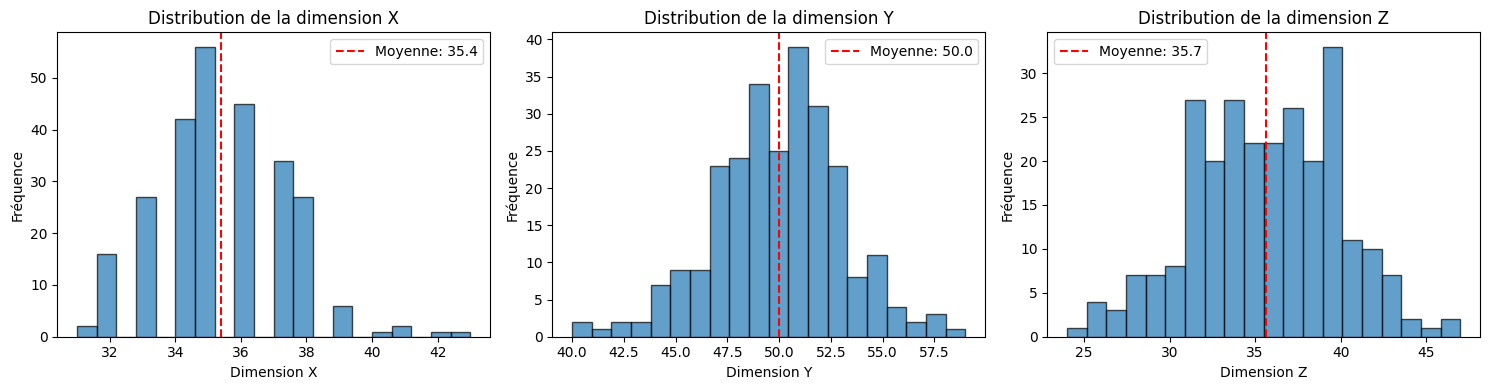

✅ Graphique sauvegardé: dimensions_distribution.png


In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, axis_name in enumerate(['X', 'Y', 'Z']):
    axes[i].hist(dimensions[:, i], bins=20, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel(f'Dimension {axis_name}')
    axes[i].set_ylabel('Fréquence')
    axes[i].set_title(f'Distribution de la dimension {axis_name}')
    axes[i].axvline(np.mean(dimensions[:, i]), color='red', 
                    linestyle='--', label=f'Moyenne: {np.mean(dimensions[:, i]):.1f}')
    axes[i].legend()

plt.tight_layout()
plt.savefig('dimensions_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Graphique sauvegardé: dimensions_distribution.png")

Analyse des intensités (5 premiers volumes)

In [18]:
print("🔢 ANALYSE DES INTENSITÉS")
print("=" * 60)

intensity_stats = []
num_samples = min(5, len(train_images))

for i in range(num_samples):
    img_path = os.path.join(IMAGES_TR, train_images[i])
    data, _ = load_nifti(img_path)
    
    stats = {
        'filename': train_images[i],
        'min': float(np.min(data)),
        'max': float(np.max(data)),
        'mean': float(np.mean(data)),
        'std': float(np.std(data)),
        'median': float(np.median(data))
    }
    intensity_stats.append(stats)
    
    print(f"\n{train_images[i]}:")
    print(f"  Min: {stats['min']:.2f}")
    print(f"  Max: {stats['max']:.2f}")
    print(f"  Mean: {stats['mean']:.2f} ± {stats['std']:.2f}")
    print(f"  Median: {stats['median']:.2f}")

print("\n" + "=" * 60)
print("⚠️ OBSERVATION: Les intensités varient beaucoup d'un volume à l'autre")
print("👉 Cela justifie la NORMALISATION (z-score ou min-max)")


🔢 ANALYSE DES INTENSITÉS

hippocampus_001.nii.gz:
  Min: 2.00
  Max: 139.00
  Mean: 63.52 ± 24.97
  Median: 63.00

hippocampus_003.nii.gz:
  Min: 0.00
  Max: 2776.88
  Mean: 482.65 ± 196.74
  Median: 482.68

hippocampus_004.nii.gz:
  Min: 0.00
  Max: 2252.49
  Mean: 453.83 ± 199.36
  Median: 458.84

hippocampus_006.nii.gz:
  Min: 0.00
  Max: 3845.23
  Mean: 704.00 ± 320.35
  Median: 705.10

hippocampus_007.nii.gz:
  Min: 0.00
  Max: 2728.51
  Mean: 565.00 ± 256.28
  Median: 563.43

⚠️ OBSERVATION: Les intensités varient beaucoup d'un volume à l'autre
👉 Cela justifie la NORMALISATION (z-score ou min-max)


Analyse du déséquilibre des classes

In [19]:
print("⚖️ ANALYSE DU DÉSÉQUILIBRE DES CLASSES")
print("=" * 60)

class_counts = defaultdict(int)
total_voxels = 0

print("⏳ Analyse des labels en cours...")

for i in range(min(10, len(train_labels))):  # Analyser 10 labels
    label_path = os.path.join(LABELS_TR, train_labels[i])
    label_data, _ = load_nifti(label_path)
    
    unique, counts = np.unique(label_data, return_counts=True)
    for val, count in zip(unique, counts):
        class_counts[int(val)] += count
        total_voxels += count

print(f"\n📊 Distribution des classes (sur {min(10, len(train_labels))} volumes):")
print("-" * 60)

for class_id in sorted(class_counts.keys()):
    count = class_counts[class_id]
    percentage = (count / total_voxels) * 100
    class_name = labels.get(str(class_id), f"Classe {class_id}")
    
    print(f"Classe {class_id} ({class_name}):")
    print(f"  Voxels: {count:,}")
    print(f"  Pourcentage: {percentage:.2f}%")
    print()

print("=" * 60)
print("⚠️ DÉSÉQUILIBRE MAJEUR DÉTECTÉ!")
print("👉 Le fond (classe 0) domine largement")
print("👉 Cela justifie l'usage de DICE LOSS ou FOCAL LOSS")


⚖️ ANALYSE DU DÉSÉQUILIBRE DES CLASSES
⏳ Analyse des labels en cours...

📊 Distribution des classes (sur 10 volumes):
------------------------------------------------------------
Classe 0 (background):
  Voxels: 603,690
  Pourcentage: 94.63%

Classe 1 (Anterior):
  Voxels: 18,162
  Pourcentage: 2.85%

Classe 2 (Posterior):
  Voxels: 16,095
  Pourcentage: 2.52%

⚠️ DÉSÉQUILIBRE MAJEUR DÉTECTÉ!
👉 Le fond (classe 0) domine largement
👉 Cela justifie l'usage de DICE LOSS ou FOCAL LOSS


Visualisation de la distribution des classes

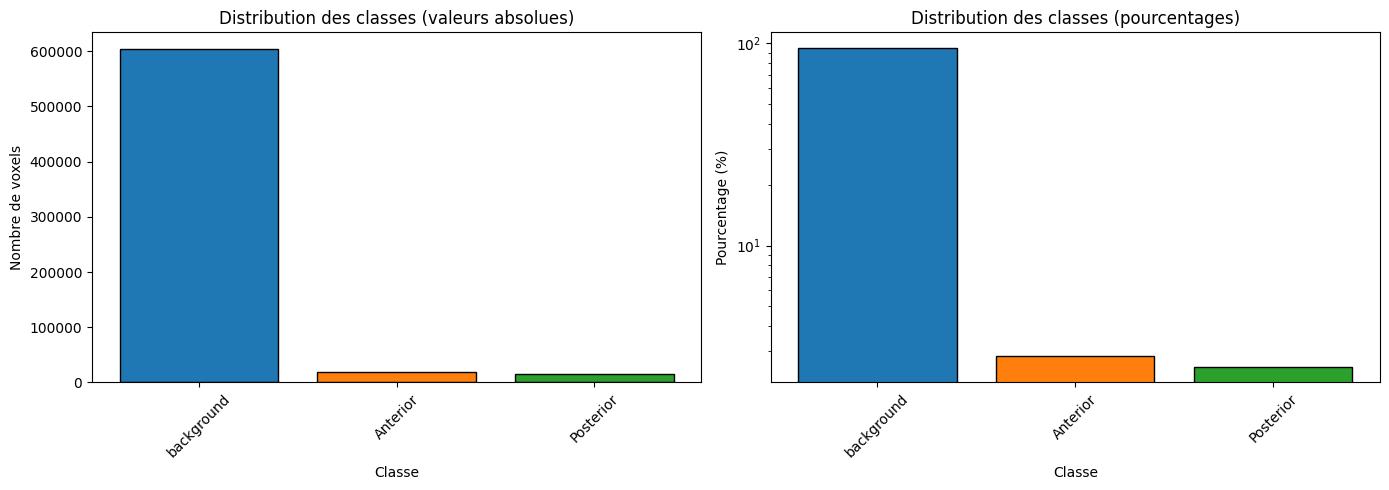

✅ Graphique sauvegardé: class_distribution.png


In [20]:
classes = list(class_counts.keys())
counts = list(class_counts.values())
percentages = [(c / total_voxels) * 100 for c in counts]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Nombres absolus
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
ax1.bar(classes, counts, color=colors[:len(classes)], edgecolor='black')
ax1.set_xlabel('Classe')
ax1.set_ylabel('Nombre de voxels')
ax1.set_title('Distribution des classes (valeurs absolues)')
ax1.set_xticks(classes)
ax1.set_xticklabels([labels.get(str(c), f"Classe {c}") for c in classes], rotation=45)

# Graphique 2: Pourcentages (échelle log)
ax2.bar(classes, percentages, color=colors[:len(classes)], edgecolor='black')
ax2.set_xlabel('Classe')
ax2.set_ylabel('Pourcentage (%)')
ax2.set_title('Distribution des classes (pourcentages)')
ax2.set_yscale('log')
ax2.set_xticks(classes)
ax2.set_xticklabels([labels.get(str(c), f"Classe {c}") for c in classes], rotation=45)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Graphique sauvegardé: class_distribution.png")

Visualisation d'un exemple (image + label)


 VISUALISATION D'UN EXEMPLE
Volume: hippocampus_001.nii.gz
Shape: (35, 51, 35)


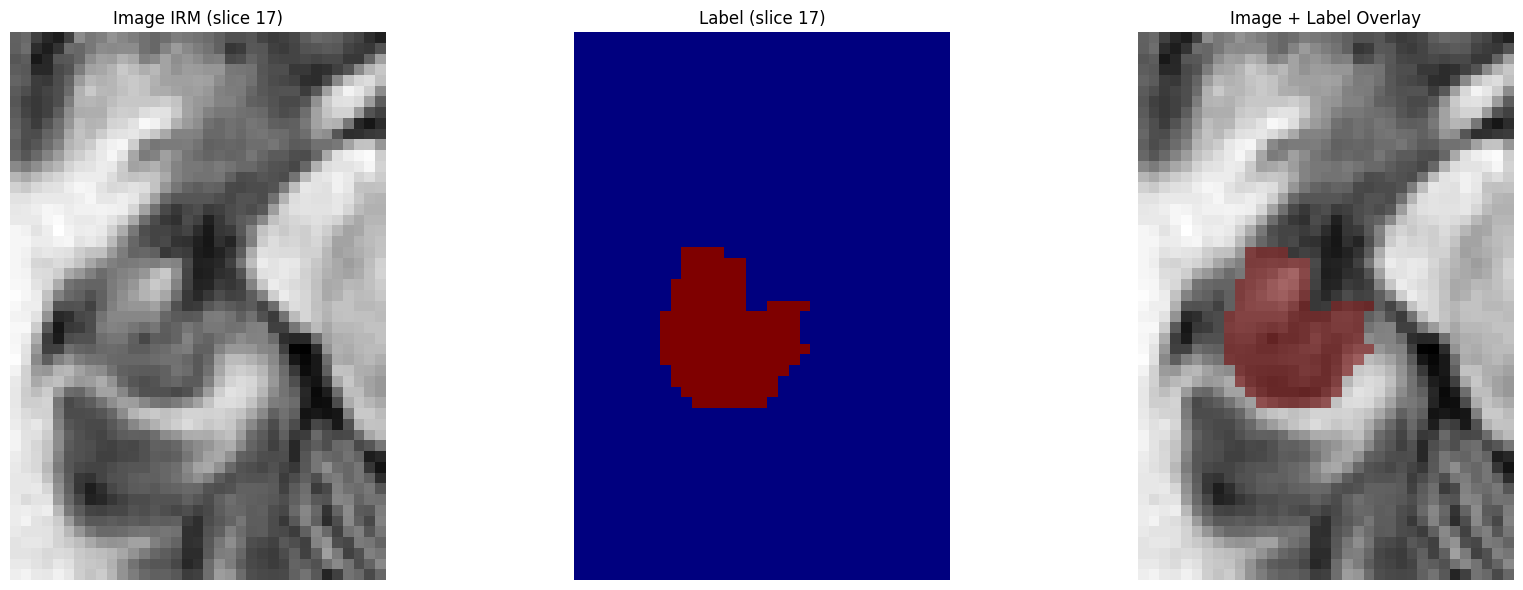

 Graphique sauvegardé: example_visualization.png


In [22]:
print(" VISUALISATION D'UN EXEMPLE")
print("=" * 60)

# Charger le premier volume
example_idx = 0
img_path = os.path.join(IMAGES_TR, train_images[example_idx])
label_path = os.path.join(LABELS_TR, train_labels[example_idx])

image_data, _ = load_nifti(img_path)
label_data, _ = load_nifti(label_path)

print(f"Volume: {train_images[example_idx]}")
print(f"Shape: {image_data.shape}")

# Prendre une coupe au milieu selon l'axe Z
slice_idx = image_data.shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Image originale
axes[0].imshow(image_data[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[0].set_title(f'Image IRM (slice {slice_idx})')
axes[0].axis('off')

# Label
axes[1].imshow(label_data[:, :, slice_idx].T, cmap='jet', origin='lower', vmin=0, vmax=2)
axes[1].set_title(f'Label (slice {slice_idx})')
axes[1].axis('off')

# Overlay
axes[2].imshow(image_data[:, :, slice_idx].T, cmap='gray', origin='lower')
mask = label_data[:, :, slice_idx].T > 0
axes[2].imshow(np.ma.masked_where(~mask, label_data[:, :, slice_idx].T), 
               cmap='jet', alpha=0.5, origin='lower', vmin=0, vmax=2)
axes[2].set_title('Image + Label Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('example_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graphique sauvegardé: example_visualization.png")


Visualisation multi-axes (axial, sagittal, coronal)

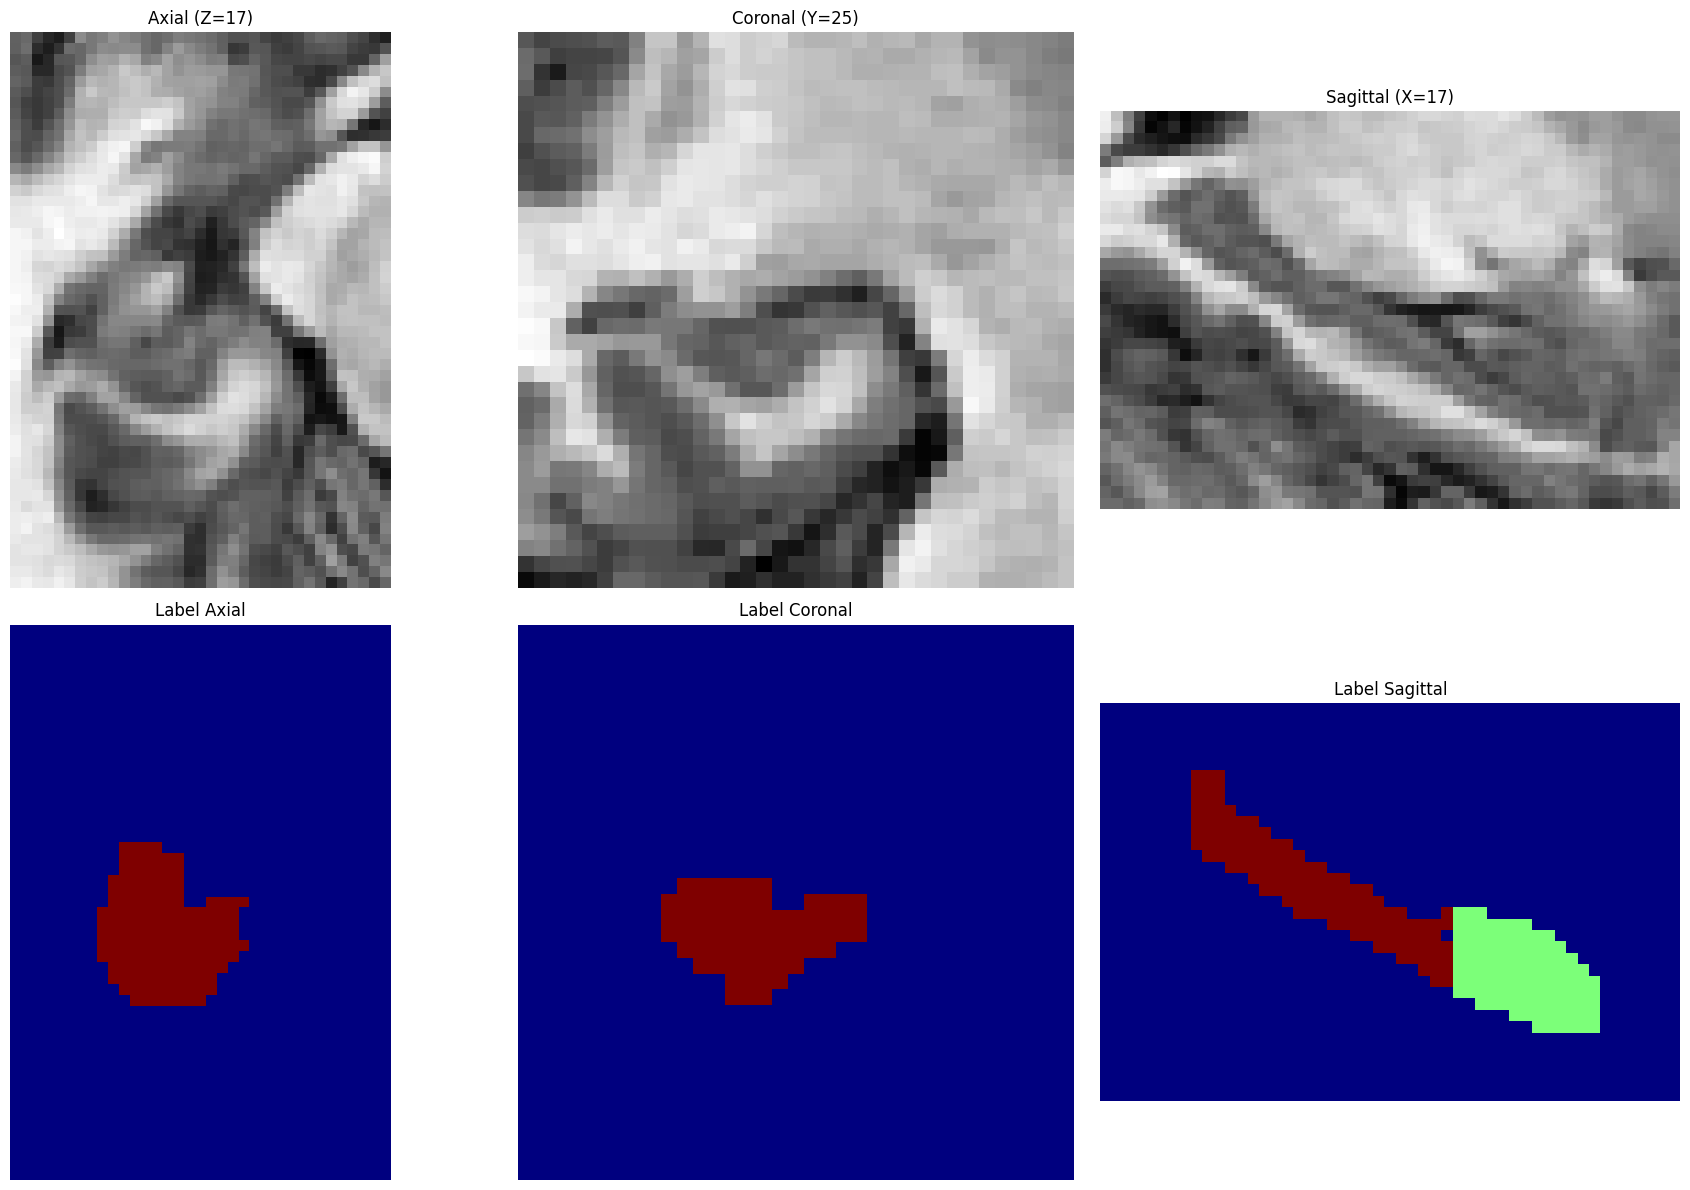

Graphique sauvegardé: multi_axis_view.png


In [23]:
slice_z = image_data.shape[2] // 2  # Axial
slice_y = image_data.shape[1] // 2  # Coronal
slice_x = image_data.shape[0] // 2  # Sagittal

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Ligne 1: Images
axes[0, 0].imshow(image_data[:, :, slice_z].T, cmap='gray', origin='lower')
axes[0, 0].set_title(f'Axial (Z={slice_z})')
axes[0, 0].axis('off')

axes[0, 1].imshow(image_data[:, slice_y, :].T, cmap='gray', origin='lower')
axes[0, 1].set_title(f'Coronal (Y={slice_y})')
axes[0, 1].axis('off')

axes[0, 2].imshow(image_data[slice_x, :, :].T, cmap='gray', origin='lower')
axes[0, 2].set_title(f'Sagittal (X={slice_x})')
axes[0, 2].axis('off')

# Ligne 2: Labels
axes[1, 0].imshow(label_data[:, :, slice_z].T, cmap='jet', origin='lower', vmin=0, vmax=2)
axes[1, 0].set_title(f'Label Axial')
axes[1, 0].axis('off')

axes[1, 1].imshow(label_data[:, slice_y, :].T, cmap='jet', origin='lower', vmin=0, vmax=2)
axes[1, 1].set_title(f'Label Coronal')
axes[1, 1].axis('off')

axes[1, 2].imshow(label_data[slice_x, :, :].T, cmap='jet', origin='lower', vmin=0, vmax=2)
axes[1, 2].set_title(f'Label Sagittal')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('multi_axis_view.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graphique sauvegardé: multi_axis_view.png")


Résumé et conclusions

In [26]:
print("\n" + "=" * 60)
print("RÉSUMÉ DE L'EXPLORATION DU DATASET")
print("=" * 60)

print(f"""
1️⃣ INFORMATIONS GÉNÉRALES
   • Dataset: {dataset_info.get('name', 'Task04_Hippocampus')}
   • Modalité: {dataset_info.get('modality', 'MRI')}
   • Nombre de volumes d'entraînement: {len(train_images)}
   • Nombre de classes: {len(labels)}

2️⃣ DIMENSIONS DES VOLUMES
   • Taille moyenne: {np.mean(dimensions, axis=0).astype(int)}
   • Taille min: {np.min(dimensions, axis=0)}
   • Taille max: {np.max(dimensions, axis=0)}
   • Tailles variables: {'Oui' if len(unique_shapes) > 1 else 'Non'}
   
   ⚠️ IMPLICATION: {"Cropping/Padding nécessaire" if len(unique_shapes) > 1 else "Pas de preprocessing de taille nécessaire"}

3️⃣ INTENSITÉS
   • Variation importante entre volumes
   • Plage de valeurs non-standardisée
   
   ⚠️ IMPLICATION: Normalisation OBLIGATOIRE (z-score recommandé)

4️⃣ DÉSÉQUILIBRE DES CLASSES
   • Classe 0 (fond): ~{percentages[0]:.1f}%
   • Classes 1+2 (hippocampe): ~{sum(percentages[1:]):.1f}%
   • Ratio: ~1:{int(percentages[0]/sum(percentages[1:]))}
   
   ⚠️ IMPLICATION: Cross-Entropy standard NE FONCTIONNERA PAS
   👉 Utiliser: Dice Loss, Focal Loss, ou combinaison

5️⃣ RECOMMANDATIONS POUR LE PREPROCESSING
   ✅ Normalisation: z-score par volume
   ✅ Data augmentation: rotations, flips, elastic deformations
   ✅ Patch-based training (optionnel, pour focuser sur l'hippocampe)
   ✅ Stratégie 2D vs 3D: tester les deux

6️⃣ PROCHAINES ÉTAPES
   1. Implémenter le preprocessing
   2. Créer le DataLoader PyTorch/TensorFlow
   3. Implémenter U-Net 2D (baseline)
   4. Tester U-Net 3D (si GPU suffisant)
   5. Comparer les résultats
""")

print("=" * 60)
print(" EXPLORATION TERMINÉE!")
print(" Graphiques générés:")
print("   • dimensions_distribution.png")
print("   • class_distribution.png")
print("   • example_visualization.png")
print("   • multi_axis_view.png")
print("=" * 60)


RÉSUMÉ DE L'EXPLORATION DU DATASET

1️⃣ INFORMATIONS GÉNÉRALES
   • Dataset: Hippocampus
   • Modalité: {'0': 'MRI'}
   • Nombre de volumes d'entraînement: 260
   • Nombre de classes: 3

2️⃣ DIMENSIONS DES VOLUMES
   • Taille moyenne: [35 49 35]
   • Taille min: [31 40 24]
   • Taille max: [43 59 47]
   • Tailles variables: Oui

   ⚠️ IMPLICATION: Cropping/Padding nécessaire

3️⃣ INTENSITÉS
   • Variation importante entre volumes
   • Plage de valeurs non-standardisée

   ⚠️ IMPLICATION: Normalisation OBLIGATOIRE (z-score recommandé)

4️⃣ DÉSÉQUILIBRE DES CLASSES
   • Classe 0 (fond): ~94.6%
   • Classes 1+2 (hippocampe): ~5.4%
   • Ratio: ~1:17

   ⚠️ IMPLICATION: Cross-Entropy standard NE FONCTIONNERA PAS
   👉 Utiliser: Dice Loss, Focal Loss, ou combinaison

5️⃣ RECOMMANDATIONS POUR LE PREPROCESSING
   ✅ Normalisation: z-score par volume
   ✅ Data augmentation: rotations, flips, elastic deformations
   ✅ Patch-based training (optionnel, pour focuser sur l'hippocampe)
   ✅ Stratégie 